# Lending Club Data Set Prediction

#### Company Information:

Lending Club is a peer to peer lending company based in the United States, in which investors provide funds for potential borrowers and investors earn a profit depending on the risk they take (the borrowers credit score). Lending Club provides the "bridge" between investors and borrowers.



#### Questions to be Answered:
    
We will use data science and exploratory data analysis to take a peek Lending Club’s loan data from 2007 to 2011, focusing on the following questions regarding this period:

Loan Absolute Variables Distribution: How does loan value, amount funded by lender and total committed by investors distribution looks like?
Applicants income range: Range of Applicants income for both good and bad loans

Defaults Volume: How many loans were defaulted?

Average Interest Rates: What was the range of interest rate for the loans?

Loan Purpose: What were the most frequent Loan Purposes?

Loan Grades: Variation of interest rates for the different grades of loans

Delinquency Breakdown: How many loans were Charged Off(Bad loans)?

How does the loan data distribution look like? Using Data Science, we will paint a picture detailing the most important aspects related to the loans and perform EDA (Exploratory Data Analysis).

Are the loan grades from LC optimal? Loan grades are critical for P2P Marketplaces, as they measure the probability of a client going incurring into default, thus being crucial for businesses’ profitability.

Can we create a better, optimized model to predict credit risk using machine learning? 

By analyzing these aspects, we will be able to understand our data better and also get to know a bit of Lending Club’s story.
The dataset contains 887K loan applications from 2007 through 2011 and it can be downloaded from the url www.lendingclub.com.
    



In [309]:
#import warnings
#warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
from numpy.random import seed
from scipy.stats import norm
from scipy.stats import ttest_ind_from_stats
df= pd.read_csv('LoanStats3a_securev1_new.csv',low_memory=False)


## Understanding the various features (columns) of the dataset


In [310]:
print(df.info())
df.head()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42542 entries, 0 to 42541
Columns: 150 entries, id to settlement_term
dtypes: float64(120), object(30)
memory usage: 48.7+ MB
None


Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag', 'debt_settlement_flag_date',
       'settlement_status', 'settlement_date', 'settlement_amount',
       'settlement_percentage', 'settlement_term'],
      dtype='object', length=150)

In [311]:
print(df.shape)

(42542, 150)


In [312]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1077501,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,NaN,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,NaN,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,NaN,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


## Data Wrangling

In [313]:
#rename the column names

df = df.rename(columns={"loan_amnt": "loan_amount", "funded_amnt": "funded_amount", "funded_amnt_inv": "investor_funds",
                       "int_rate": "interest_rate", "annual_inc": "annual_income"})


In [314]:
df.head()
print(type(df['interest_rate'][0]))

<class 'str'>


In [315]:
#removing percentage sign from the interest_rate and convert it to float from string
df.interest_rate = df.interest_rate.str.replace('%', '').astype('float64')
print(df.interest_rate.head())

0    10.65
1    15.27
2    15.96
3    13.49
4    12.69
Name: interest_rate, dtype: float64


In [316]:
#remove months from term colums
df.term = df.term.str.replace('months', '')
df.term.head()

0    36 
1    60 
2    36 
3    36 
4    60 
Name: term, dtype: object

In [317]:
#setting up the index
df.set_index('id')

#member_id column shows Nan value and is of less significance hence we drop it
df.drop(['member_id'],axis=1,inplace=True)

In [318]:
missing_fractions = df.isnull().mean().sort_values(ascending=False)
missing_fractions.head(20)

inq_fi                            1.0
percent_bc_gt_75                  1.0
mths_since_recent_bc_dlq          1.0
mths_since_recent_inq             1.0
mths_since_recent_revol_delinq    1.0
num_accts_ever_120_pd             1.0
num_actv_bc_tl                    1.0
num_actv_rev_tl                   1.0
num_bc_sats                       1.0
num_bc_tl                         1.0
num_il_tl                         1.0
num_op_rev_tl                     1.0
num_rev_accts                     1.0
num_rev_tl_bal_gt_0               1.0
num_sats                          1.0
num_tl_120dpd_2m                  1.0
num_tl_30dpd                      1.0
num_tl_90g_dpd_24m                1.0
num_tl_op_past_12m                1.0
mths_since_recent_bc              1.0
dtype: float64

Text(0, 0.5, 'Feature count')

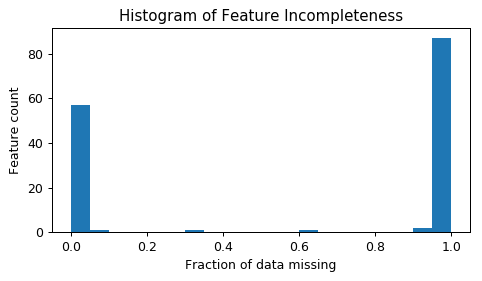

In [319]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

From the above histogram, we see there's a large gap between features missing "some" data (<20%) and those missing "lots" of data (>40%). Because it's generally very difficult to accurately impute data with more than 30% missing values, we drop such columns. First store all variables missing more than 30% data in an alphabetical list:

In [320]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(len(drop_list))
df.drop(labels=drop_list, axis=1, inplace=True)
df.shape

91


(42542, 58)

So now we dropped the columns with more than 30% missing values and hare left with 58 columns.

In [321]:
print(df.columns)
df.info()

Index(['id', 'loan_amount', 'funded_amount', 'investor_funds', 'term',
       'interest_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_income', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies',

In [322]:
df['emp_title'].describe()



count       39909
unique      30656
top       US Army
freq          139
Name: emp_title, dtype: object

There are too many different job titles for this feature to be useful, so we drop it.




In [323]:
df.drop(labels='emp_title', axis=1, inplace=True)

In [324]:
df['emp_length'].value_counts(dropna=False).sort_index()

1 year       3595
10+ years    9369
2 years      4743
3 years      4364
4 years      3649
5 years      3458
6 years      2375
7 years      1875
8 years      1592
9 years      1341
< 1 year     5062
NaN          1119
Name: emp_length, dtype: int64

In the above column we need to change the details of 10+ years and <1 year into a readable format which is done below:

In [325]:
df['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
df['emp_length'].replace('< 1 year', '0 years', inplace=True)

Now we convert hte employee length into an int value :

In [326]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
df['emp_length'] = df['emp_length'].apply(emp_length_to_int)
df['emp_length'].value_counts(dropna=False).sort_index()

0.0     5062
1.0     3595
2.0     4743
3.0     4364
4.0     3649
5.0     3458
6.0     2375
7.0     1875
8.0     1592
9.0     1341
10.0    9369
NaN     1119
Name: emp_length, dtype: int64

Because of the large range of incomes, we should take a log transform of the annual income variable.


In [327]:

df['log_annual_inc'] = df['annual_income'].apply(lambda x: np.log10(x+1))
df['log_annual_inc'].describe()

count    42531.000000
mean         4.764398
std          0.246615
min          3.278067
25%          4.602071
50%          4.770859
75%          4.916459
max          6.778151
Name: log_annual_inc, dtype: float64

In [328]:
df["loan_status"].value_counts()


Fully Paid                                             34116
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64

In [329]:
# Determining the loans that are bad from loan_status column

bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]


df['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
    
    
df['loan_condition'] = df['loan_status'].apply(loan_condition)

### Pie Chart for Loan Conditions

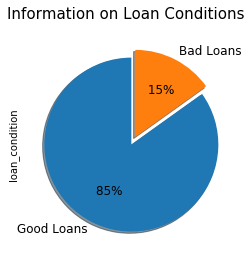

In [330]:
#f, ax = plt.subplots(1,2, figsize=(16,8))

labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=15)

df["loan_condition"].value_counts().plot.pie(explode=[0,0.10],autopct='%3.0f%%', shadow=True,labels=labels, fontsize=12, startangle=90)




The above pie chart shows that the data is imbalanced and it has 85% of good loans and 15% of bad loans . We might have to do oversampling of the bad loans for better results at the end . That will be decided after building the model for this data at later stage.

In [331]:
df['income_category'] = np.nan
lst = [df]

for col in lst:
    col.loc[col['annual_income'] <= 100000, 'income_category'] = 'Low'
    col.loc[(col['annual_income'] > 100000) & (col['annual_income'] <= 200000), 'income_category'] = 'Medium'
    col.loc[col['annual_income'] > 200000, 'income_category'] = 'High'

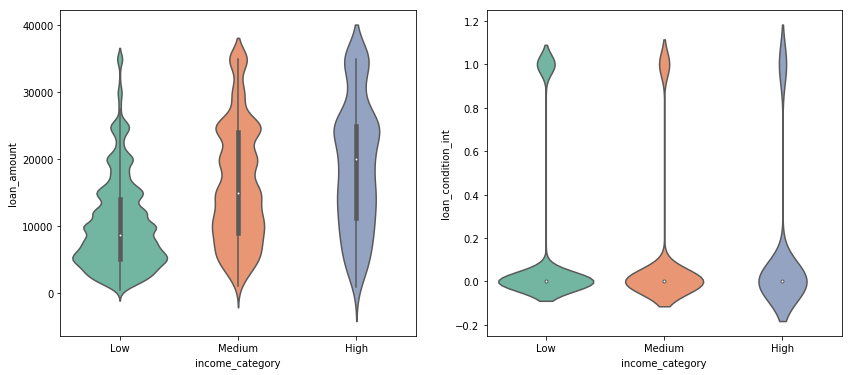

In [332]:
# Let's transform the column loan_condition into integrers.

lst = [df]
df['loan_condition_int'] = np.nan

for col in lst:
    col.loc[df['loan_condition'] == 'Good Loan', 'loan_condition_int'] = 0 # Negative (Bad Loan)
    col.loc[df['loan_condition'] == 'Bad Loan', 'loan_condition_int'] = 1 # Positive (Good Loan)
    
# Convert from float to int the column (This is our label)  
df['loan_condition_int'] = df['loan_condition_int'].astype(int)
fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(14,6))

sns.violinplot(x="income_category", y="loan_amount", data=df, palette="Set2", ax=ax1 )
sns.violinplot(x="income_category", y="loan_condition_int", data=df, palette="Set2", ax=ax2)


#### Loan Condition V/s Income

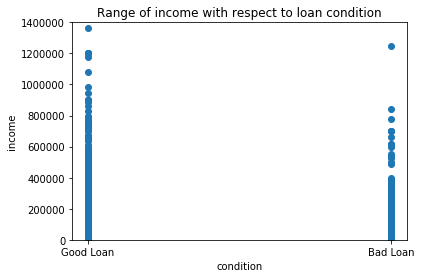

In [333]:
plt.scatter(df.loan_condition,df.annual_income)
plt.xlabel("condition")
plt.ylabel("income")
plt.ylim(0,1400000)
plt.title("Range of income with respect to loan condition")
plt.show()

#### Loan Condition V/s Fico Scores

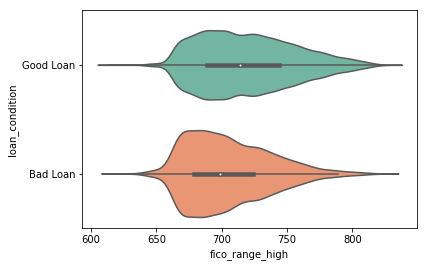

In [334]:
sns.violinplot(x="fico_range_high", y="loan_condition", data=df, palette="Set2" )
plt.show()

The mean of the good loans is more than 700 and most of the values of fico_score lies near 700 score hence the fico score for good loans should be closer to 700.

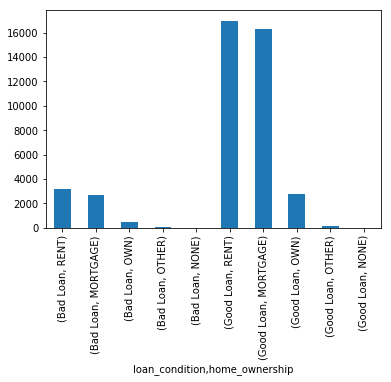

In [335]:
df.home_ownership.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()

Loan Grades and Subgrades are assigned by Lending Club based on the borrower’s credit worthiness and also on some variables specific to that Loan.

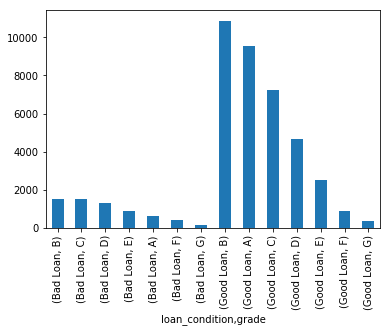

In [336]:
df.grade.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()

The majority of loans is either graded as B or C — together these correspond to more than 50% of the loan population.
While there is a considerable amount of A graded or “prime” loans (~17%), there is a small amount of E graded, or “uncollectible” loans (~0,06%). Which is a good sign for Lending Club.
But, are these the right grades?

### Data visualization to see how the loan value, amount funded by lender and total committed by investors distribution looks like?

/Users/ankit/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/ankit/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/ankit/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/ankit/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0.5, 1.0, 'Total committed by Investors')

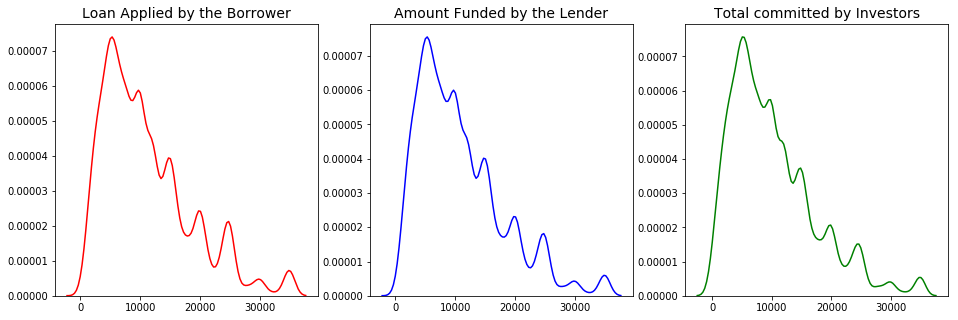

In [337]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amount = df["loan_amount"].values
funded_amount = df["funded_amount"].values
investor_funds = df["investor_funds"].values
sns.distplot(loan_amount, ax=ax[0], color="red",bins=(100,100))
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(funded_amount, ax=ax[1], color="blue",bins=(100,100))
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.distplot(investor_funds, ax=ax[2], color="green",bins=(100,100))
ax[2].set_title("Total committed by Investors", fontsize=14)

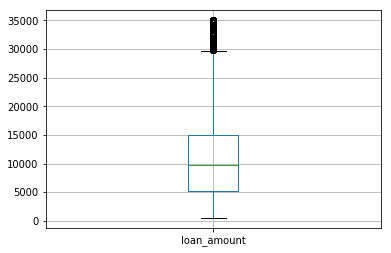

In [338]:
df.boxplot(column='loan_amount')


In [339]:
mean =np.mean(df.funded_amount)
std =np.std(df.funded_amount)
print(mean)
print(std)

10821.585752909368
7146.830662349949


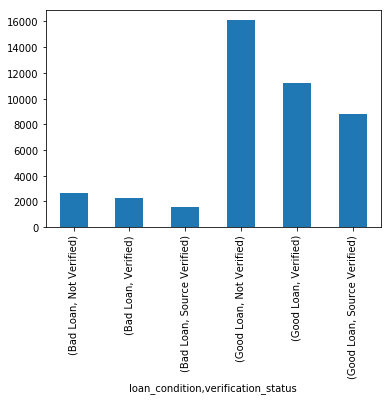

In [340]:
df.verification_status.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()


In [341]:
pd.crosstab(df ['verification_status'], df ['loan_condition'], margins=True)


loan_condition,Bad Loan,Good Loan,All
verification_status,,,
Not Verified,2655,16103,18758
Source Verified,1534,8772,10306
Verified,2242,11229,13471
All,6431,36104,42535


This shows that 41.3% of the bad loans were not verified.

In [342]:
df[['fico_range_low', 'fico_range_high']].describe()


,fico_range_low,fico_range_high
count,42535.000000,42535.000000
mean,713.052545,717.052545
std,36.188439,36.188439
min,610.000000,614.000000
25%,685.000000,689.000000
50%,710.000000,714.000000
75%,740.000000,744.000000
max,825.000000,829.000000


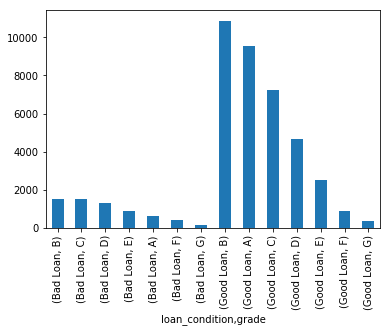

In [343]:
df.grade.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()

Number of bad loans were less in the category A jobs and it had more number of good loans as compared to the other category.

  # Statistical Inferences

We want to check whether the interest rates offered for A grade loans were lesser than the other grades hence we are going to use single tail Welch's t-test as the variance is not equal.

$H_{0}$ : The  interest rates offered for other grade loans is greater than the A grade loan.


$H_{1}$ : The  interest rates offered for other grade loans is not greater than the A grade loan.

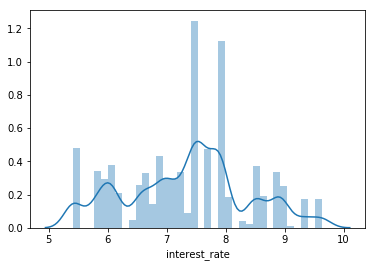

In [344]:
x=df.interest_rate[df.grade=='A']
sns.distplot(x)


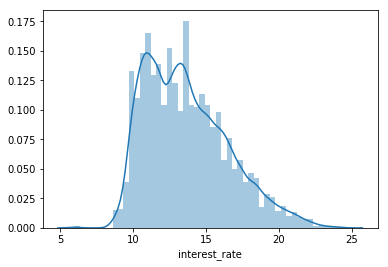

In [345]:
x=df.interest_rate[df.grade!='A']
x = x[np.logical_not(np.isnan(x))]
sns.distplot(x)


In [346]:
def loan_sampler_A(n):
    return np.random.choice(df.interest_rate[df.grade=='A'].astype('float64'), n)
def loan_sampler_other(n):
    return np.random.choice(df.interest_rate[df.grade!='A'].astype('float64'),n)

In [347]:
seed(47)
size=50
sample1 = loan_sampler_A(size)
sample2 = loan_sampler_other(size)
type(sample1[0])

numpy.float64

In [348]:
mean_A = np.mean(sample1)
mean_other = np.mean(sample2)
std_A=np.std(sample1)
std_other=np.std(sample2)
seed(47)
N=500
# take your samples here
total_mean_A=np.empty(N)
total_mean_other=np.empty(N)
for i in range (N):
    total_mean_A[i]=np.mean(loan_sampler_A(size))
    total_mean_other[i]=np.mean(loan_sampler_other(size))


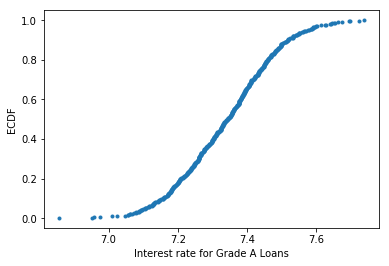

In [349]:
n=len(total_mean_A)
x=np.sort(total_mean_A)
y=np.arange(1,n+1)/n
plt.plot(x,y,marker='.',linestyle='none')
# Label the axes
plt.xlabel('Interest rate for Grade A Loans')
plt.ylabel('ECDF')
plt.show()

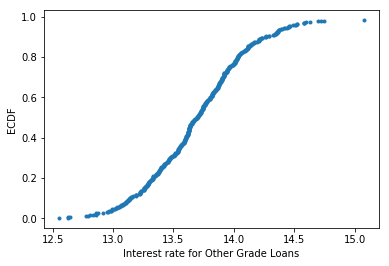

In [350]:
n=len(total_mean_other)
x=np.sort(total_mean_other)
y=np.arange(1,n+1)/n
plt.plot(x,y,marker='.',linestyle='none')
# Label the axes
plt.xlabel('Interest rate for Other Grade Loans')
plt.ylabel('ECDF')
plt.show()

It is very much clear from the above ECDF graph that the interest rates for the other grades lies in the range of (12.5,15)

In [351]:
total_mean_other = total_mean_other[np.logical_not(np.isnan(total_mean_other))]


In [352]:
from scipy import stats
import scipy.stats
print(stats.ttest_ind(total_mean_other,total_mean_A,equal_var=False))

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
print("The confidence interval for A grade loans is: "+str(mean_confidence_interval(total_mean_A)))
print("The confidence interval for all other loan other than A grade loans is:"+ str(mean_confidence_interval(total_mean_other)))
           
      

Ttest_indResult(statistic=324.96013788823643, pvalue=0.0)
The confidence interval for A grade loans is: (7.339761200000001, 7.327202348671294, 7.352320051328707)
The confidence interval for all other loan other than A grade loans is:(13.687281466395113, 13.651015426092169, 13.723547506698058)


Here, the p value is less than 0.05 hence the result is of high significance .Hence, we reject the null hypothesis.

### Correlation among the features

Few important columns are selected from the full dataset based on the significance and the data present prior to the approval of the loan. The columns are saved in 'imp_columns' list.

Now we will see the correlation between the numerical data

In [353]:
imp_columns=['loan_amount','term','interest_rate','grade','emp_length','home_ownership','annual_income','verification_status','loan_status','loan_condition','purpose','title','addr_state','fico_range_low','fico_range_high','income_category']
df2=df[imp_columns]
df2.corr()

,loan_amount,interest_rate,emp_length,annual_income,fico_range_low,fico_range_high
loan_amount,1.000000,0.292346,0.158339,0.276122,0.133232,0.133232
interest_rate,0.292346,1.000000,0.000062,0.054365,-0.702587,-0.702587
emp_length,0.158339,0.000062,1.000000,0.115990,0.089997,0.089997
annual_income,0.276122,0.054365,0.115990,1.000000,0.052027,0.052027
fico_range_low,0.133232,-0.702587,0.089997,0.052027,1.000000,1.000000
fico_range_high,0.133232,-0.702587,0.089997,0.052027,1.000000,1.000000


employee length,annual income and fico scores have strong positive correlation with the loan amount .

In [354]:
df[imp_columns].head()

,loan_amount,term,interest_rate,grade,emp_length,home_ownership,annual_income,verification_status,loan_status,loan_condition,purpose,title,addr_state,fico_range_low,fico_range_high,income_category
0,5000.0,36,10.65,B,10.0,RENT,24000.0,Verified,Fully Paid,Good Loan,credit_card,Computer,AZ,735.0,739.0,Low
1,2500.0,60,15.27,C,0.0,RENT,30000.0,Source Verified,Charged Off,Bad Loan,car,bike,GA,740.0,744.0,Low
2,2400.0,36,15.96,C,10.0,RENT,12252.0,Not Verified,Fully Paid,Good Loan,small_business,real estate business,IL,735.0,739.0,Low
3,10000.0,36,13.49,C,10.0,RENT,49200.0,Source Verified,Fully Paid,Good Loan,other,personel,CA,690.0,694.0,Low
4,3000.0,60,12.69,B,1.0,RENT,80000.0,Source Verified,Fully Paid,Good Loan,other,Personal,OR,695.0,699.0,Low


Correlation between all the important columns:

In [355]:
df2.apply(lambda x: x.factorize()[0]).corr()
corr_imp=df2.apply(lambda x: x.factorize()[0]).corr()
print(corr_imp)

                     loan_amount      term  interest_rate     grade  \
loan_amount             1.000000  0.049321       0.004888  0.038821   
term                    0.049321  1.000000      -0.229188  0.174308   
interest_rate           0.004888 -0.229188       1.000000  0.080418   
grade                   0.038821  0.174308       0.080418  1.000000   
emp_length             -0.015373 -0.021818      -0.002423  0.001704   
home_ownership          0.015785  0.101269      -0.046499 -0.007129   
annual_income           0.022134 -0.036130       0.180196  0.011177   
verification_status    -0.019865 -0.260850       0.216612 -0.076179   
loan_status             0.049661  0.008709       0.273700  0.193024   
loan_condition          0.032362  0.133752       0.023507  0.112504   
purpose                -0.027695  0.001936       0.018901  0.010115   
title                   0.003469 -0.200983       0.570702  0.033934   
addr_state              0.005964  0.012570       0.027204  0.004016   
fico_r

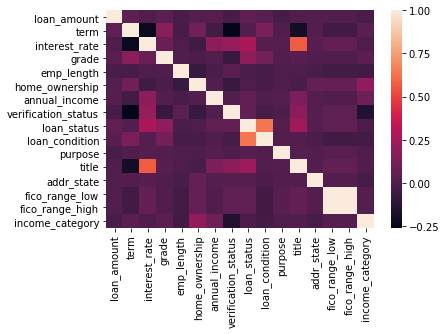

In [356]:
import seaborn as sns

sns.heatmap(corr_imp, 
        xticklabels=corr_imp.columns,
        yticklabels=corr_imp.columns)

# Model Building

In [357]:
# Convert all non-numeric values to number
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
for var in df.columns:
    le = LabelEncoder()
    df[var]=df[var].astype('str')
    df[var]=le.fit_transform(df[var])


In [358]:
from sklearn import preprocessing
target_name='loan_condition'
y= df.loan_condition
X= df.drop(target_name,axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, random_state=123)
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=5)

In [359]:
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [360]:
Y_predict=knn.predict(X_test)
#y_predict=y_predict.reshape(-1,1)

In [361]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, Y_predict))

Accuracy: 0.9310831139526138


We got an accuracy of 0.93 . As our model has good loans dominating the sample we may need to over sample our data with bad sample.

We would now check the effect on the accuracy by changing n in the model and the graph is plotted below:

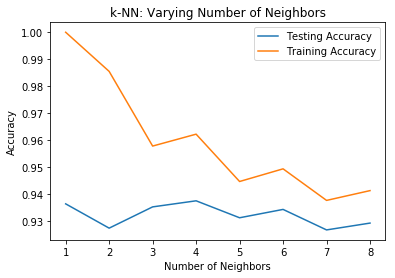

In [362]:
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
from sklearn.neighbors import KNeighborsClassifier
# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,Y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, Y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, Y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()


From the above graph we can see that we get best result at n= 4 which gives us training accuracy as 0.96 and testing accuracy as 0.94

### Confusion Matrix

In [363]:
#Random Forest
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10000, random_state = 42)
rf.fit(X_train, Y_train);
predictions = rf.predict(X_test)
cm = confusion_matrix(Y_test,predictions)
print(cm)

#Decision Tree

from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)
predictions = clf.predict(X_test)
cm2 = confusion_matrix(Y_test,predictions)
print(cm2)

[[1608    0]
 [   0 9028]]
[[1608    0]
 [   0 9028]]


In [364]:
from sklearn.metrics import recall_score
print (clf.score(X_test, Y_test))
print (recall_score(Y_test, clf.predict(X_test)))


1.0
1.0


Imbalanced datasets can be seen everywhere. Usually banks want to predict fraudulent credit card charges but only a small fraction of observations are actually positives. I’d guess that only 1 in 10,000 credit card charges are fraudulent, at most. Recently, oversampling the minority class observations has become a common approach to improve the quality of predictive modeling. By oversampling, models are sometimes better able to learn patterns that differentiate classes.

### Using imblearn for oversampling

In [365]:
!pip install imblearn


In [366]:
from imblearn.over_sampling import SMOTE

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train,
                                                  test_size = .3,
                                                  random_state=123)
sm = SMOTE(random_state=123)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)
clf_rf = RandomForestClassifier(n_estimators=1000, random_state=123)
clf_rf.fit(x_train_res, y_train_res)
print(y_train_res)
print ('Validation Results')
print( clf_rf.score(x_val, y_val))
print (recall_score(y_val, clf_rf.predict(x_val)))
print (clf_rf.score(X_test, Y_test))
print (recall_score(y_test, clf_rf.predict(X_test)))


[0 1 1 ... 0 0 0]
Validation Results
1.0
1.0
1.0
1.0


We see that the recall score and precision score comes out to be 1, which does not seen to be right. it can also be because of the dominating class of good loans or some other dominating features.

We can use check the important features in the model:

In [367]:
!pip install tabulate


In [368]:
from tabulate import tabulate
model = clf_rf.fit(X_train, Y_train)
headers = ["name", "score"]
values = sorted(zip(X_train.columns, model.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))

name                              score
loan_status                 0.281725
loan_condition_int          0.273198
recoveries                  0.225039
collection_recovery_fee     0.120456
last_credit_pull_d          0.0258278
last_fico_range_low         0.0220151
last_fico_range_high        0.0217922
total_rec_late_fee          0.00312538
funded_amount               0.00264734
total_rec_prncp             0.00251706
sub_grade                   0.00244401
debt_settlement_flag        0.00231675
grade                       0.00168734
loan_amount                 0.00159987
interest_rate               0.00154694
term                        0.00137368
investor_funds              0.00127642
total_rec_int               0.00107401
installment                 0.000915142
total_pymnt                 0.000866923
last_pymnt_d                0.000742396
total_pymnt_inv             0.000717986
fico_range_low              0.000619525
last_pymnt_amnt             0.000614174
fico_range_high             0

We can see that few features such as:
loan_status,loan_condition_int,recoveries,collection_recovery_fee,last_credit_pull_d,total_rec_late_fee,total_rec_int,installment,total_pymnt,last_pymnt_d,total_pymnt_inv are to be dropped due to there insignificance/unavailability before the approval or similar terms to the loan_condition(target variable).

Hence we drop the above columns from the new data set and train our model again.

In [369]:
type(df)

pandas.core.frame.DataFrame

In [370]:
delete=['loan_status','recoveries','collection_recovery_fee','last_credit_pull_d','total_rec_late_fee','total_rec_int','installment','total_pymnt','last_pymnt_d','total_pymnt_inv']
df.drop(delete,axis=1,inplace=True)


In [371]:
for var in df.columns:
    le = LabelEncoder()
    df[var]=df[var].astype('str')
    df[var]=le.fit_transform(df[var])
df.drop('loan_condition_int',axis=1,inplace=True)
target_name='loan_condition'
y= df.loan_condition
X= df.drop(target_name,axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, random_state=123)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train,
                                                  test_size = .3,
                                                  random_state=123)
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)
clf_rf = RandomForestClassifier(n_estimators=1000, random_state=123)
clf_rf.fit(x_train_res, y_train_res)
print ('Validation Results')
print( clf_rf.score(x_val, y_val))
print (recall_score(y_val, clf_rf.predict(x_val)))
print ('Test Results')
print (clf_rf.score(X_test, Y_test))
print (recall_score(Y_test, clf_rf.predict(X_test)))
#le.inverse_transform([0, 0, 1, 2])


Validation Results
0.8879022147931467
0.9444308145240432
Test Results
0.8820985332831892
0.9388568896765618


##### Now we can see some realistic results when we have removed the after approval columns from the data set.
Hence, few features were dominating our model which have been removed from the feature list.
This gives us a validation score of 0.86

We can see the model seems pretty good as their has been very less variation in the score of the test set and the validation set.
We will also deal with the same dataset by oversampling manually.

### Creating a Balanced Dataset Manually

In [372]:
print(df.loan_condition.values)

[1 0 1 ... 1 1 1]


In [373]:
bad_loans=df[df.loan_condition.values==0]
print(bad_loans.shape)
good_loans=df[df.loan_condition.values==1][:int(bad_loans.shape[0]*0.66)]
print(good_loans.shape)

(6431, 50)
(4244, 50)


It shows that out of 43000 datasets 6431 data represents the bad loans . So to make our dataset balanced we will create a new dataset "balanced" coprising both the type in 3:2 ratio

In [378]:
balanced_df=pd.concat([bad_loans,good_loans])
balanced_df.shape

(10675, 50)

In [379]:
# Convert all non-numeric values to number
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
for var in balanced_df.columns:
    le = LabelEncoder()
    balanced_df[var]=balanced_df[var].astype('str')
    balanced_df[var]=le.fit_transform(balanced_df[var])


### Now we will use the above balanced data set to run and improve our model 

Wewill be using two models separately to plot the ROC curve using the manually over sampled data.The two models to be used are:


1) KNN Classifier
  2)Logistic Regression

In [380]:
#knn Classifier
from sklearn import preprocessing
target_name='loan_condition'
y_balanced= balanced_df['loan_condition']
X_balanced= balanced_df.drop(target_name,axis=1)


In [381]:
from sklearn.model_selection import train_test_split
X_train_balanced, X_test_balanced, Y_train_balanced, Y_test_balanced = train_test_split(X_balanced, y_balanced, stratify=y_balanced, random_state=123)
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_balanced, Y_train_balanced)
Y_predict_balanced=knn.predict(X_test_balanced)
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test_balanced, Y_predict_balanced))



Accuracy: 0.6489321843387036


In [382]:
recall_score(Y_test_balanced,Y_predict_balanced)

0.5240339302544769

In [383]:
from sklearn.metrics import classification_report
print(classification_report(Y_test_balanced, knn.predict(X_test_balanced), digits=4))


              precision    recall  f1-score   support

           0     0.6996    0.7313    0.7151      1608
           1     0.5628    0.5240    0.5427      1061

    accuracy                         0.6489      2669
   macro avg     0.6312    0.6277    0.6289      2669
weighted avg     0.6452    0.6489    0.6466      2669



In [384]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test_balanced, Y_predict_balanced)


In [385]:
print("False Positive Rate"+str(fpr))
print("True Positive Rate"+str(tpr))
print("Treshold"+str(thresholds))

False Positive Rate[0.         0.26865672 1.        ]
True Positive Rate[0.         0.52403393 1.        ]
Treshold[2 1 0]


In [386]:
roc_auc=metrics.auc(fpr, tpr)


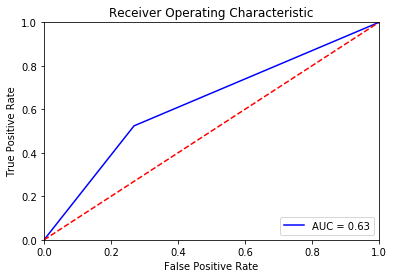

In [387]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Using Logistic Regression for the above balanced dataset

In [388]:
from sklearn.linear_model import LogisticRegression
lr= LogisticRegression()
X_lr_train,X_lr_test,y_lr_train,y_lr_test=train_test_split(X_balanced, y_balanced, random_state=123)


In [389]:
lr.fit(X_lr_train, y_lr_train)


/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [390]:
print(lr.coef_)
print(lr.intercept_)

[[ 1.05069031e-01  1.49945157e-04 -7.25457286e-05 -1.27129403e-04
  -3.76923827e-01 -6.34920728e-04 -4.84585748e-01 -1.92713323e-02
   1.12096218e-02 -6.44587457e-03 -7.75467719e-06  2.13250233e-01
   6.58307616e-02  0.00000000e+00 -1.05006988e-01 -3.47476731e-02
  -9.90186147e-05 -3.49859121e-04 -4.30537653e-03 -1.12202737e-04
  -4.57324888e-02 -1.46064695e-04  3.79923786e-03  3.79923786e-03
  -1.01768128e-02 -6.84276577e-03 -1.54298585e-01 -4.23143936e-05
   2.09164153e-04 -7.96188612e-04  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -6.34169300e-05 -1.45056225e-05  1.67153643e-02
   9.31524391e-03 -1.47967487e-02  0.00000000e+00  0.00000000e+00
  -1.83464674e-03 -1.47967487e-02 -1.83464674e-03 -8.50066863e-01
  -3.28132888e-03  0.00000000e+00 -5.78765791e-01 -1.23786561e-04
   6.58666819e-02]]
[-0.79670961]


In [391]:
y_lr_pred = lr.predict(X_lr_test)


In [392]:
confusion_matrix(y_lr_test, y_lr_pred)


array([[1299,  321],
       [ 373,  676]])

In [393]:
recall_score(y_lr_test, y_lr_pred, average='macro')  


0.7231375560498534

In [394]:
from sklearn.metrics import precision_score

precision_score(y_lr_test, y_lr_pred, average='macro')  


0.7274739889525035

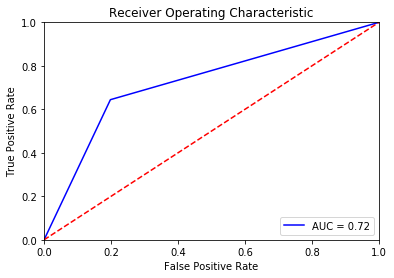

False Positive Rate[0.         0.19814815 1.        ]
True Positive Rate[0.         0.64442326 1.        ]
Treshold[2 1 0]


In [395]:
fpr, tpr, thresholds = metrics.roc_curve(y_lr_test, y_lr_pred)
roc_auc=metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("False Positive Rate"+str(fpr))
print("True Positive Rate"+str(tpr))
print("Treshold"+str(thresholds))

Our precision score has improved to 0.73 using logistic regression.

On the training set, we compute the Pearson correlation, $F$-statistic, and $p$ value of each predictor with the response variable charged_off.



In [397]:

linear_dep = pd.DataFrame()
for col in X_lr_train.columns:
    linear_dep.loc[col, 'pearson_corr'] = X_lr_train[col].corr(y_lr_train)
linear_dep['abs_pearson_corr'] = abs(linear_dep['pearson_corr'])



In [398]:
from sklearn.feature_selection import f_classif
for col in X_lr_train.columns:
    mask = X_lr_train[col].notnull()
    (linear_dep.loc[col, 'F'], linear_dep.loc[col, 'p_value']) = f_classif(pd.DataFrame(X_lr_train.loc[mask, col]), y_lr_train.loc[mask])


/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [0] are constant.
  UserWarning)
/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [0] are constant.
  UserWarning)
/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [0] are constant.
  UserWarning)
/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_div

Sort the results by the absolute value of the Pearson correlation:



In [399]:
linear_dep.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_dep.drop('abs_pearson_corr', axis=1, inplace=True)


Reset the index:



In [400]:
linear_dep.reset_index(inplace=True)
linear_dep.rename(columns={'index':'variable'}, inplace=True)



View the results for the top 20 predictors most correlated with charged_off:



In [401]:

linear_dep.head(20)

,variable,pearson_corr,F,p_value
0,issue_d,0.348538,1106.765682,2.013476e-227
1,grade,-0.303534,812.270913,2.966116e-170
2,last_fico_range_high,0.261521,587.607228,2.518588e-125
3,last_fico_range_low,0.240806,492.701703,5.529379e-106
4,pub_rec_bankruptcies,-0.168312,233.354705,5.951227e-52
5,term,-0.129487,136.491143,2.793326e-31
6,pub_rec,-0.110699,99.299270,2.964555e-23
7,debt_settlement_flag,-0.100951,82.409046,1.372916e-19
8,verification_status,0.077342,48.166643,4.220454e-12
9,interest_rate,0.074254,44.376214,2.888735e-11


### We will be proceeding for an Ensembled Learning Model to give much better result and hence we will now observe the performance of Six models together using a FOR loop.

The six models used below are:
    
1)LogisticRegression


2)DecisionTreeClassifier


3)LinearDiscriminantAnalysis


4)SVC


5)KNeighborsClassifier


6)MultinomialNB


#### Six models on the balanced data:

In [406]:
from sklearn.model_selection import train_test_split
train_X,val_X,train_y,val_y=train_test_split(X_train_balanced,Y_train_balanced,random_state=123)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

models=[]
models.append(("logreg",LogisticRegression()))
models.append(("tree",DecisionTreeClassifier()))
models.append(("lda",LinearDiscriminantAnalysis()))
models.append(("svc",SVC()))
models.append(("knn",KNeighborsClassifier()))
models.append(("nb",MultinomialNB()))
seed=123
scoring='accuracy'
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
result=[]
names=[]
for name,model in models:
    #print(model)
    kfold=KFold(n_splits=10,random_state=seed)
    model.fit(train_X,train_y)
    y1_predict=model.predict(val_X)
    cv_result=cross_val_score(model,train_X,train_y,cv=kfold,scoring=scoring)
    result.append(cv_result)
    names.append(name)
    print("Results on the Test Data: %s %f %f %f %f" % (name,cv_result.mean(),cv_result.std(),recall_score(Y_test_balanced, model.predict(X_test_balanced), average='macro'),precision_score(Y_test_balanced, model.predict(X_test_balanced), average='macro')))  
    print("Results on the Validation data: %f %f" % (recall_score(val_y, model.predict(val_X), average='macro'),precision_score(val_y, model.predict(val_X), average='macro')))


/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

Results on the Test Data: logreg 0.729180 0.022243 0.737546 0.742152
Results on the Validation data: 0.721736 0.726542
Results on the Test Data: tree 0.882575 0.018107 0.885590 0.889125
Results on the Validation data: 0.884807 0.885403


/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("V

Results on the Test Data: lda 0.738006 0.024670 0.738838 0.741548
Results on the Validation data: 0.725525 0.728460


/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/ankit/anaconda3/lib/python3.7/site-packages/skle

Results on the Test Data: svc 0.605763 0.022685 0.500000 0.301236


/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Results on the Validation data: 0.500000 0.296204
Results on the Test Data: knn 0.641071 0.018189 0.622495 0.626699
Results on the Validation data: 0.640372 0.644752
Results on the Test Data: nb 0.534643 0.025895 0.537188 0.535632
Results on the Validation data: 0.548731 0.547077


It seems like logistic regressio, Decision Tree and LDA models agree to each other.Hence we will finally use this models into our Ensemble Techniques as our main aim is to increase the Precision and accuracy(decrease the False Positives which are more dangerous in our case).


# Ensemble Model

This method combines the decisions from multiple models to improve the overall performance. This can be achieved in various ways,the first method which we would use is Max Voting.

### Max voting Ensemble Method 

In [408]:
from sklearn.ensemble import VotingClassifier
model1 = LogisticRegression()
model2 = LinearDiscriminantAnalysis()
model3 = DecisionTreeClassifier()
model_final = VotingClassifier(estimators=[('lr', model1), ('ld', model2),('tree',model3)], voting='hard')
model_final.fit(train_X,train_y)
print("The accuracy score of the test model using the Max Voting Ensemble Method is:")
print (model_final.score(X_test_balanced,Y_test_balanced))

/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy score of the test model using the Max Voting Ensemble Method is:
0.7703259647808168


/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [409]:
print(classification_report(Y_test_balanced, model_final.predict(X_test_balanced), digits=4))


              precision    recall  f1-score   support

           0     0.8024    0.8209    0.8116      1608
           1     0.7188    0.6937    0.7060      1061

    accuracy                         0.7703      2669
   macro avg     0.7606    0.7573    0.7588      2669
weighted avg     0.7692    0.7703    0.7696      2669



We can see that the Ensemble Method has improved our model to a great extend. Our precision for both 0 and 1 has increaed.

#### The last model which we can train our model is the 

### Advanced Ensemble Method of Bagging meta-estimator

Bagging meta-estimator is an ensembling algorithm that can be used for both classification (BaggingClassifier) and regression (BaggingRegressor) problems. It follows the typical bagging technique to make predictions. Following are the steps for the bagging meta-estimator algorithm:

Random subsets are created from the original dataset (Bootstrapping).
The subset of the dataset includes all features.
A user-specified base estimator is fitted on each of these smaller sets.
Predictions from each model are combined to get the final result.:

In [412]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
model1 = BaggingClassifier(DecisionTreeClassifier())
model1.fit(train_X, train_y)
print("The score using the Decision Tree bagging Classifier is:")
print(model1.score(X_test_balanced,Y_test_balanced))


The score using the Decision Tree bagging Classifier is:
0.9085799925065567


We can see that there has been a good increase in the score using bagging classifier and the score has now become 0.91.

In [413]:
from sklearn.metrics import roc_auc_score


In [414]:
y_score = model1.predict_proba(X_test_balanced)[:,1]
roc_auc_score(Y_test_balanced, y_score)

0.9708743042562868

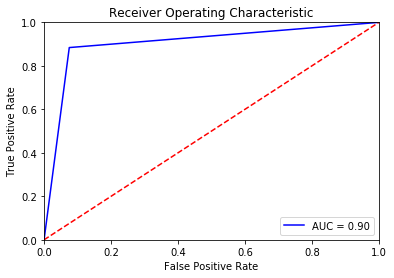

False Positive Rate[0.         0.07524876 1.        ]
True Positive Rate[0.         0.88407163 1.        ]
Treshold[2 1 0]


In [415]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test_balanced, model1.predict(X_test_balanced))
roc_auc=metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("False Positive Rate"+str(fpr))
print("True Positive Rate"+str(tpr))
print("Treshold"+str(thresholds))

In [416]:
print(classification_report(Y_test_balanced, model1.predict(X_test_balanced), digits=4))


              precision    recall  f1-score   support

           0     0.9236    0.9248    0.9242      1608
           1     0.8857    0.8841    0.8849      1061

    accuracy                         0.9086      2669
   macro avg     0.9047    0.9044    0.9045      2669
weighted avg     0.9086    0.9086    0.9086      2669



Here we generate a classification report to check the performance of our Bagging Classifier model. You can see the random forest works on “0” prediction very well, which means it can confidently tell you who is the bad customer which was the main importance for our model. Also, it has a pretty good recall when predicting the loan default behaviours. In laymen’s terms, recall means how many cases are predicted correctly among all the true conditions. 

## Conclusion

We applied machine learning methods to predict the probability that a requested loan on LendingClub will charge off/turn into a bad loan. After training and evaluating with different models (logistic regression, random forest, and Decision tree)and finally using ensemble method we found that in all the cases Decision tree performed the best.We selected Decision tree Bagging Classifier as our final model with AUC SCORE 0.9 on a test set.

Using this model can provide a somewhat informed prediction of the likelihood that a loan will charge off, using only data available to potential investors before the loan is fully funded.The major importance by far was found as the FICO score and the annual income. Hence, deviating from the basic prnciples of banking(FICO) would be risky for an investor.

We also found that, according to the Pearson correlations between the predictors and the response, the most important variables for predicting charge-off are the loan interest rate and term, and the borrower's FICO score and debt-to-income ratio.